# Evaluate melt rates (circumpolar and Amundsen Sea)

In [121]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.plots import circumpolar_plot, finished_plot
from nemo_python_git.constants import rho_ice, sec_per_year, sec_per_day

In [21]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
run_folder    = f'{base_dir}output/ERA5_test6/'
nemo_mesh     = f'{base_dir}bathymetry/mesh_mask-20240305.nc'
nemo_domain   = f'{base_dir}bathymetry/domain_cfg-20240305.nc'

In [48]:
def mask_land(nemo_mesh, file_var):
    mask = (nemo_mesh.tmask.isel(nav_lev=0) != 0) | (nemo_mesh.misf == 0)
    lon_plot = np.ma.masked_where(mask, nemo_mesh.nav_lon.values)
    lat_plot = np.ma.masked_where(mask, nemo_mesh.nav_lat.values)
    plot_var = np.ma.masked_where(mask, file_var.values)
    return lon_plot, lat_plot, plot_var 

def plot_land(nemo_mesh, file_var):
    mask = (nemo_mesh.misf!=0) 
    lon_plot = np.ma.masked_where(mask, nemo_mesh.nav_lon.values)
    lat_plot = np.ma.masked_where(mask, nemo_mesh.nav_lat.values)
    plot_var = np.ma.masked_where(mask, file_var.values)
    return lon_plot, lat_plot, plot_var 

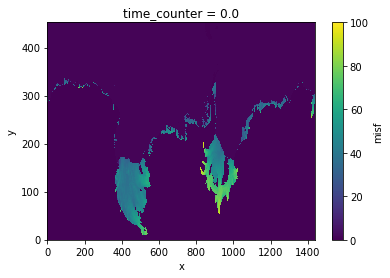

In [25]:
nemo_mesh_ds.misf.isel(time_counter=0).plot()

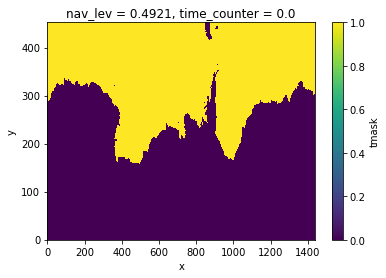

In [32]:
nemo_mesh_ds.tmask.isel(nav_lev=0).plot()

## Ice shelf melt rates

In [27]:
nemo_mesh_ds = xr.open_dataset(nemo_mesh).isel(time_counter=0)
mesh_sub  = nemo_mesh_ds.isel(x=slice(450, 900), y=slice(130,350))

#### Amundsen Sea

In [125]:
nemo_ds.fwfisf

<xarray.DataArray 'fwfisf' (time_counter: 12, y_grid_T: 453, x_grid_T: 1440)>
[7827840 values with dtype=float32]
Coordinates:
    nav_lat_grid_T  (y_grid_T, x_grid_T) float32 ...
    nav_lon_grid_T  (y_grid_T, x_grid_T) float32 ...
    time_centered   (time_counter) datetime64[ns] 1979-01-16T12:00:00 ... 197...
  * time_counter    (time_counter) datetime64[ns] 1979-01-16T12:00:00 ... 197...
Dimensions without coordinates: y_grid_T, x_grid_T
Attributes:
    long_name:           Ice shelf fresh water flux ( from isf to oce )
    units:               kg/m2/s
    online_operation:    average
    interval_operation:  1350 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 1350 s)
    cell_measures:       area: area_grid_T

In [132]:
from calendar import monthrange

# load nemo simulations
gridT_files = glob.glob(f'{run_folder}files/*SBC*')
# nemo_ds     = xr.open_mfdataset(gridT_files) # load all the gridT files in the run folder
nemo_ds   = xr.open_dataset(gridT_files[0])
days_per_month = [monthrange(nemo_ds.time_counter.dt.year[i].values, nemo_ds.time_counter.dt.month[i].values)[1] for i in range(0,12)]
nemo_ds   = nemo_ds.assign({'days_per_month':(('time_counter'), days_per_month)})
melt_rate = ((nemo_ds.fwfisf)*nemo_ds['days_per_month']*sec_per_day).sum(dim='time_counter')/rho_ice

In [115]:
nemo_ds.time_counter[0].dt.year

<xarray.DataArray 'year' ()>
array(1979)
Coordinates:
    time_centered  datetime64[ns] 1979-01-16T12:00:00
    time_counter   datetime64[ns] 1979-01-16T12:00:00

In [133]:
melt_rate_sub = melt_rate.isel(x_grid_T=slice(450, 900), y_grid_T=slice(130,350))

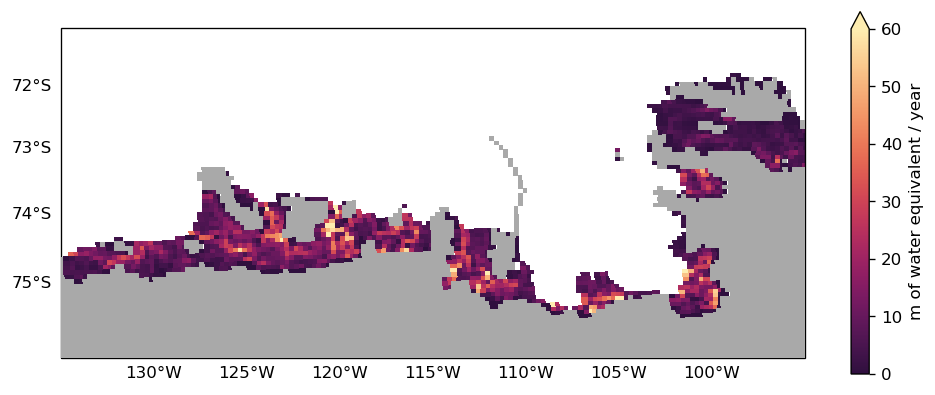

In [134]:
# Check that the observations depth is close enough to the bottom bathymetry to be considered representative

# Select the NEMO variables we need and time-average    
lon_land, lat_land, land_plt = plot_land(mesh_sub, mesh_sub.bathy_metry)

#------------- Plot figure -----------------
fig, ax = plt.subplots(1,1, figsize=(10,4), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)}, dpi=120)

ax.set_extent([-95, -135, -76, -71], ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True);
gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

# kg/m2/s / kg/m3 --> m/s *sec_per_year --> m / year
lon_plt, lat_plt, var_plt = mask_land(mesh_sub, melt_rate_sub)
img = ax.pcolormesh(lon_plt, lat_plt, var_plt, transform=ccrs.PlateCarree(), rasterized=True, vmin=0, vmax=60, cmap=cmocean.cm.matter_r)
ax.pcolormesh(lon_land, lat_land, land_plt, transform=ccrs.PlateCarree(), rasterized=True, cmap=cl.ListedColormap(['DarkGrey']), zorder=3)
plt.colorbar(img, ax=ax, extend='max', label='m of water equivalent / year')

## Circumpolar Antarctic

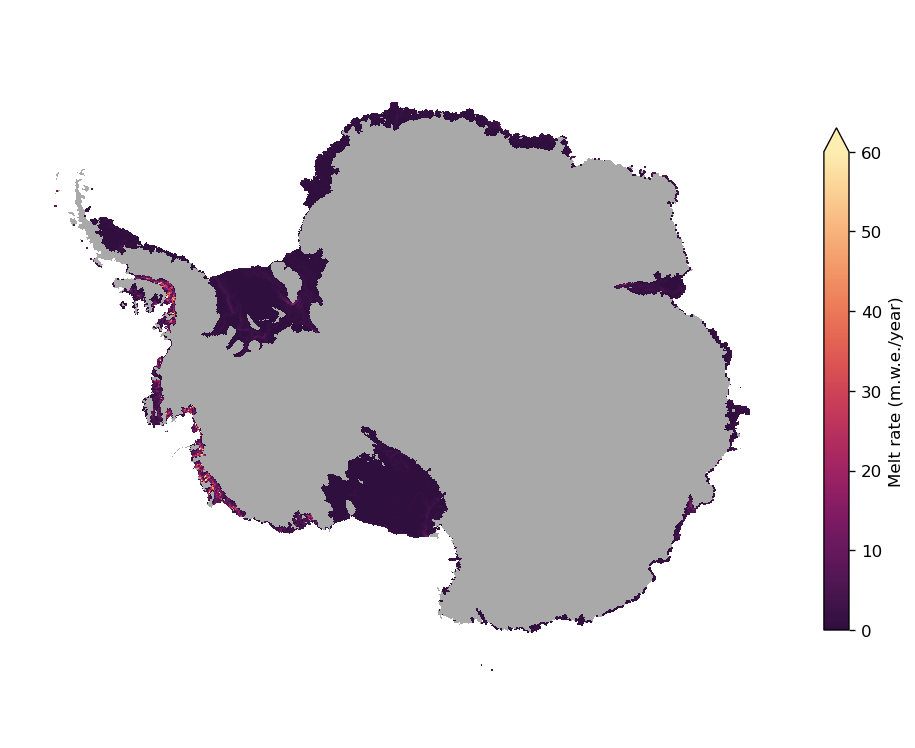

In [135]:
fig, ax = plt.subplots(1,1, figsize=(9,8), dpi=120)
img = circumpolar_plot(melt_rate, nemo_mesh_ds, ax=ax, masked=False, make_cbar=False, title='',
                       vmin=0, vmax=60, ctype=cmocean.cm.matter_r, shade_land=True, lat_max=-63)

plt.colorbar(img, ax=ax, extend='max', label='Melt rate (m.w.e./year)', fraction=0.03)

# Combine into a generalized plot that does everything

In [ ]:
# Check that the observations depth is close enough to the bottom bathymetry to be considered representative

# Select the NEMO variables we need and time-average    
lon_land, lat_land, land_plt = plot_land(mesh_sub, mesh_sub.bathy_metry)

#------------- Plot figure -----------------
fig, ax = plt.subplots(1,2, figsize=(10,4), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)}, dpi=120)

ax.set_extent([-95, -135, -76, -71], ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True);
gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

# kg/m2/s / kg/m3 --> m/s *sec_per_year --> m / year
lon_plt, lat_plt, var_plt = mask_land(mesh_sub, melt_rate_sub)
img = ax.pcolormesh(lon_plt, lat_plt, var_plt, transform=ccrs.PlateCarree(), rasterized=True, vmin=0, vmax=60, cmap=cmocean.cm.matter_r)
ax.pcolormesh(lon_land, lat_land, land_plt, transform=ccrs.PlateCarree(), rasterized=True, cmap=cl.ListedColormap(['DarkGrey']), zorder=3)
plt.colorbar(img, ax=ax, extend='max', label='m of water equivalent / year')